In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.models import ResNeXt50_32X4D_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
# Configurations
train_dir = "Data/train" 
test_dir = "Data/test"
batch_size = 32
num_classes = 3
num_epochs = 30
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),        
    transforms.RandomHorizontalFlip(),       
    transforms.RandomRotation(15),            
    transforms.ColorJitter(                   
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    transforms.ToTensor(),                    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(256),                   
    transforms.CenterCrop(224),               
    transforms.ToTensor(),                   
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225]),
])

In [4]:
# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Model 
model = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [6]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Training and Validation Functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    accuracy = 100.0 * correct / total
    return running_loss / len(loader), accuracy

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    return running_loss / len(loader), accuracy

In [8]:
# Training Loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/30
Train Loss: 0.3747, Train Accuracy: 85.26%
Val Loss: 1.1335, Val Accuracy: 94.41%
Epoch 2/30
Train Loss: 0.2105, Train Accuracy: 91.99%
Val Loss: 1.1707, Val Accuracy: 94.88%
Epoch 3/30
Train Loss: 0.1833, Train Accuracy: 92.77%
Val Loss: 1.5160, Val Accuracy: 93.40%
Epoch 4/30
Train Loss: 0.1619, Train Accuracy: 94.03%
Val Loss: 0.7638, Val Accuracy: 92.16%
Epoch 5/30
Train Loss: 0.1625, Train Accuracy: 93.84%
Val Loss: 0.2750, Val Accuracy: 94.02%
Epoch 6/30
Train Loss: 0.1411, Train Accuracy: 94.62%
Val Loss: 0.3543, Val Accuracy: 94.10%
Epoch 7/30
Train Loss: 0.1403, Train Accuracy: 94.83%
Val Loss: 0.4115, Val Accuracy: 95.11%
Epoch 8/30
Train Loss: 0.1166, Train Accuracy: 95.68%
Val Loss: 0.2649, Val Accuracy: 95.42%
Epoch 9/30
Train Loss: 0.1281, Train Accuracy: 95.45%
Val Loss: 0.2342, Val Accuracy: 95.19%
Epoch 10/30
Train Loss: 0.1152, Train Accuracy: 95.76%
Val Loss: 0.3819, Val Accuracy: 94.88%
Epoch 11/30
Train Loss: 0.1004, Train Accuracy: 96.29%
Val Loss: 0.21

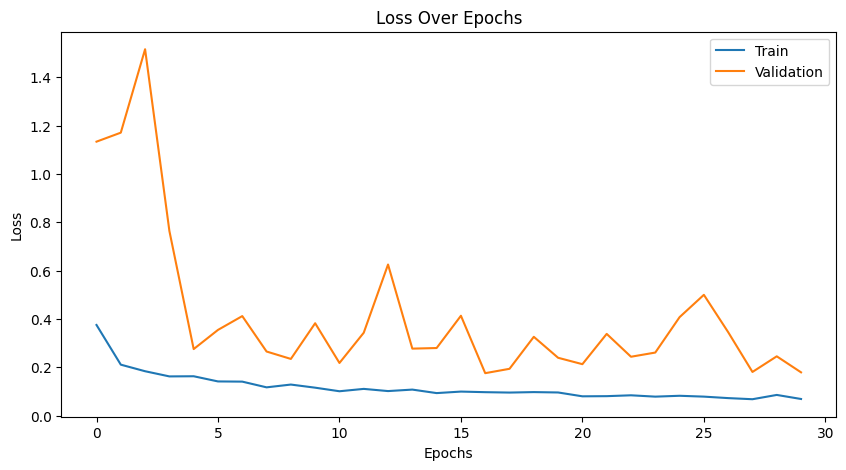

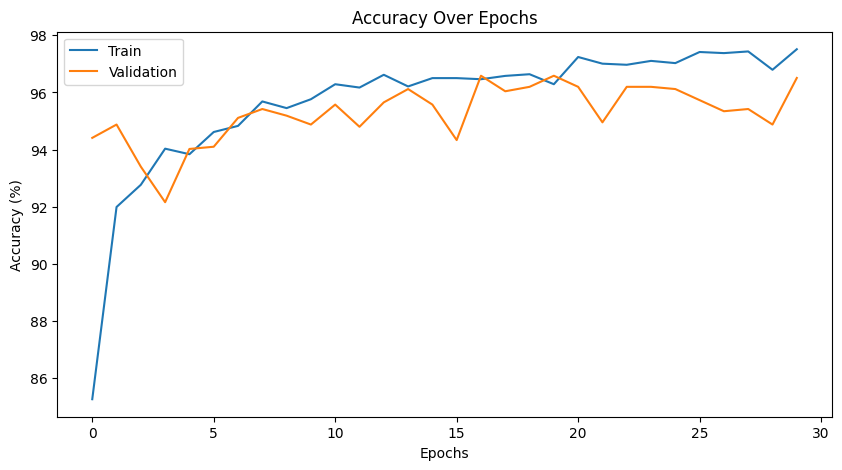

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'resnext_chest_xray.pth')

# Plot Loss and Accuracy
def plot_metrics(train, val, title, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_metrics(train_losses, val_losses, 'Loss Over Epochs', 'Loss')
plot_metrics(train_accuracies, val_accuracies, 'Accuracy Over Epochs', 'Accuracy (%)')

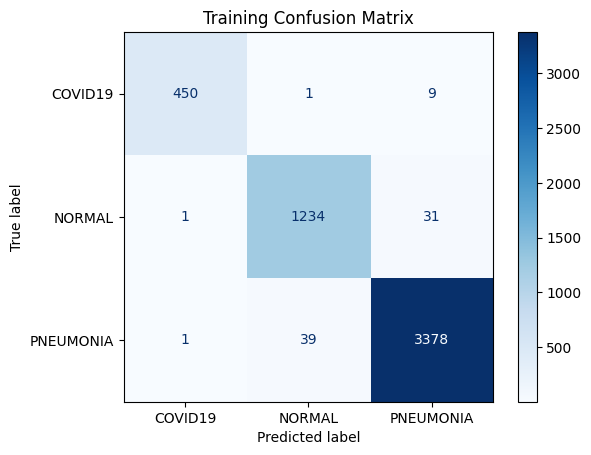

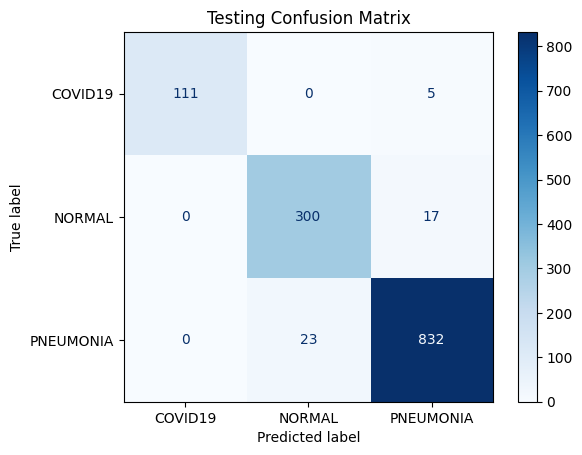

In [ ]:
# Confusion Matrix
def compute_confusion_matrix(loader, model, device, class_names):
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    return disp

class_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
compute_confusion_matrix(train_loader, model, device, class_names).plot(cmap=plt.cm.Blues)
plt.title('Training Confusion Matrix')
plt.show()

compute_confusion_matrix(test_loader, model, device, class_names).plot(cmap=plt.cm.Blues)
plt.title('Testing Confusion Matrix')
plt.show()
